# Long Short Term Memory (LSTM) 
# For Predicting Stock Price Trend

# 1. Importing Data

### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the stock price data

In [2]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [3]:
stock_name='AAPL'

In [4]:
key = 'LXRAWDV9NCEMH1QL'
ts = TimeSeries(key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol=stock_name,interval='1min', outputsize='full')

In [5]:
data=data.iloc[::-1]

# 2. Overview of data

In [6]:
data

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2020-11-03 04:01:00,109.3511,109.4010,109.3511,109.4010,1368.0
2020-11-03 04:02:00,109.5208,109.7105,109.5208,109.5807,4237.0
2020-11-03 04:03:00,109.5208,109.5508,109.4909,109.4909,3065.0
2020-11-03 04:05:00,109.4210,109.6107,109.4210,109.4310,1579.0
2020-11-03 04:06:00,109.4310,109.4310,109.4310,109.4310,407.0
...,...,...,...,...,...
2020-11-16 19:56:00,119.9400,119.9500,119.9200,119.9200,3214.0
2020-11-16 19:57:00,119.9300,119.9400,119.9200,119.9400,2831.0
2020-11-16 19:58:00,119.9300,119.9400,119.9300,119.9400,2859.0


In [7]:
len(data.iloc[:,0:1].values)

9049

In [8]:
Keep_Days=1000
training_set=data.iloc[:-Keep_Days,0:1].values
len(training_set)

8049

# 3. Feature engineering

### Feature Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Creating a data structure with 100 timesteps and 1 output

In [10]:
n=100

In [11]:
X_train = []
y_train = []
for i in range(n, len(training_set)):
    X_train.append(training_set_scaled[i-n:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 4. Model building

## Building and Training the LSTM

### Importing the Keras libraries and packages

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the LSTM

In [14]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [15]:
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [16]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [17]:
regressor.add(LSTM(units = 25, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [18]:
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.2))

### Adding the output layer

In [19]:
regressor.add(Dense(units = 1))

# 5. Compiling the LSTM

In [20]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the LSTM to the Training set

In [21]:
regressor.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
249/249 [==============================] - 46s 185ms/step - loss: 0.0205
Epoch 2/30
249/249 [==============================] - 47s 188ms/step - loss: 0.0111
Epoch 3/30
249/249 [==============================] - 49s 195ms/step - loss: 0.0086
Epoch 4/30
249/249 [==============================] - 48s 193ms/step - loss: 0.0071
Epoch 5/30
249/249 [==============================] - 48s 193ms/step - loss: 0.0055
Epoch 6/30
249/249 [==============================] - 48s 192ms/step - loss: 0.0044
Epoch 7/30
249/249 [==============================] - 52s 210ms/step - loss: 0.0036
Epoch 8/30
249/249 [==============================] - 48s 193ms/step - loss: 0.0031
Epoch 9/30
249/249 [==============================] - 48s 194ms/step - loss: 0.0026
Epoch 10/30
249/249 [==============================] - 49s 198ms/step - loss: 0.0025
Epoch 11/30
249/249 [==============================] - 48s 192ms/step - loss: 0.0021
Epoch 12/30
249/249 [==============================] - 48s 192ms/step - lo

# 6. Making the predictions

In [22]:
real_stock_price = data.iloc[-Keep_Days:, 0:1].values

In [23]:
len(real_stock_price)

1000

### Getting the predicted stock price

In [24]:
#dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = data.iloc[len(data)- len(real_stock_price) -n:,0:1].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(n, n+len(real_stock_price)):
    X_test.append(inputs[i-n:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# 7. Visualising the results

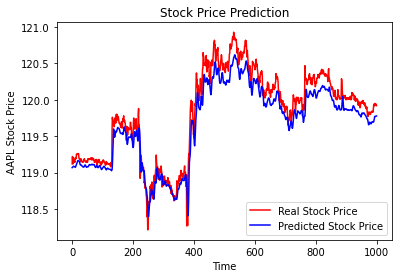

In [25]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(stock_name+' Stock Price')
plt.legend()
plt.show()

# 6. Summary

* Scraping Data using Alpha Vantage for Apple stock price as an example,
* Data size: Around 10,000 row corresponding to 10,000 time intevals 
* Model: LSTM for predicting the stock price. 
* Evaluating the built LSTM based on defined loss function
* Result were promising.

LSTM is also applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition, and anomaly detection in network traffic or intrusion detection systems.